In [3]:
!pip install keras.preprocessing.image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement keras.preprocessing.image (from versions: none)
ERROR: No matching distribution found for keras.preprocessing.image


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import tqdm
import random
from keras_preprocessing.image import load_img
warnings.filterwarnings('ignore')

In [8]:
input_path = []
label = []

for class_name in os.listdir("project"):
    for path in os.listdir("project/"+class_name):
        if class_name == 'bio':
            label.append(0)
        else:
            label.append(1)
        input_path.append(os.path.join("project", class_name, path))
print(input_path[0], label[0])

project/bio/TRAIN.1_BIODEG_ORI_313.jpg 0


In [10]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
df

images  label
0      project/bio/TRAIN.1_BIODEG_ORI_371.jpg      0
1    project/nbio/TRAIN.1_NBIODEG_CCW_184.jpg      1
2      project/bio/TRAIN.1_BIODEG_ORI_135.jpg      0
3      project/bio/TRAIN.1_BIODEG_ORI_307.jpg      0
4       project/bio/TRAIN.1_BIODEG_ORI_82.jpg      0
..                                        ...    ...
995    project/bio/TRAIN.1_BIODEG_ORI_246.jpg      0
996  project/nbio/TRAIN.1_NBIODEG_CCW_292.jpg      1
997  project/nbio/TRAIN.1_NBIODEG_CCW_395.jpg      1
998  project/nbio/TRAIN.1_NBIODEG_CCW_122.jpg      1
999    project/bio/TRAIN.1_BIODEG_ORI_375.jpg      0

[1000 rows x 2 columns]

In [11]:
######
for i in df['images']:
    if '.jpg' not in i:
        print(i)

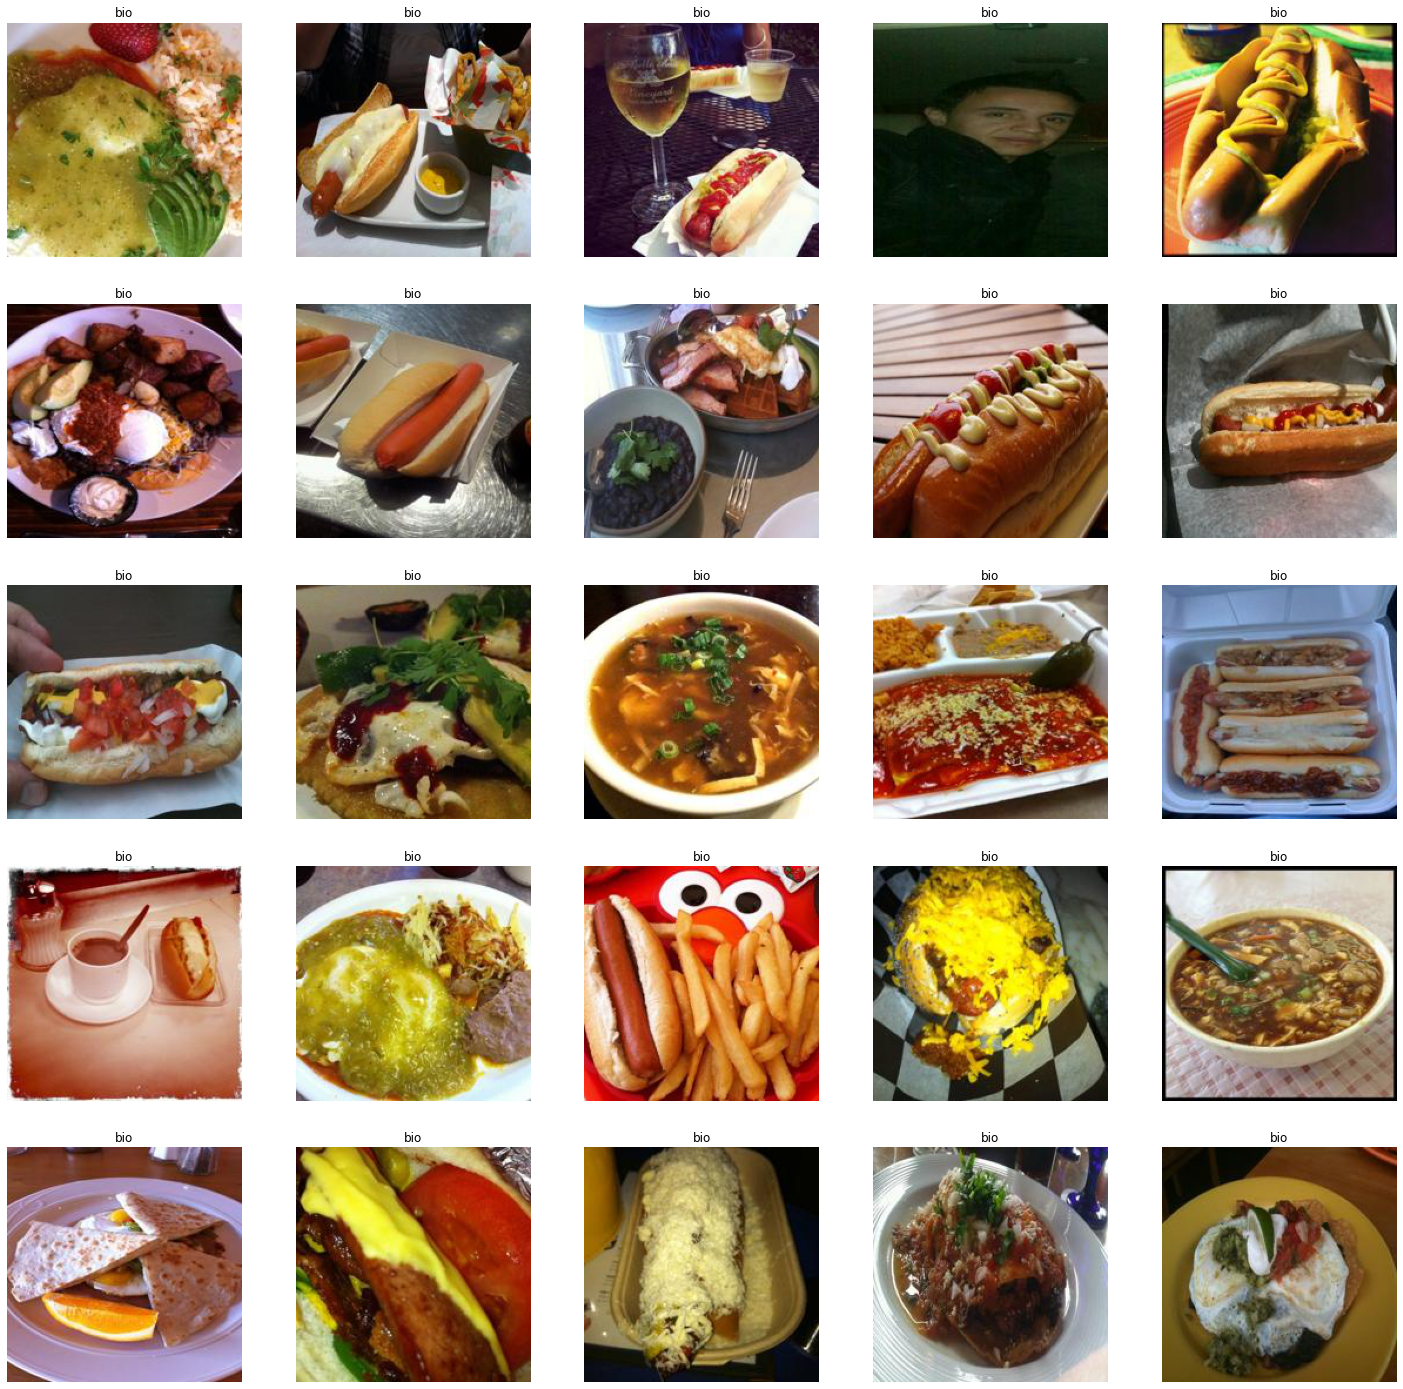

In [12]:
plt.figure(figsize=(25,25))
temp = df[df['label']==0]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('bio')
    plt.axis('off')

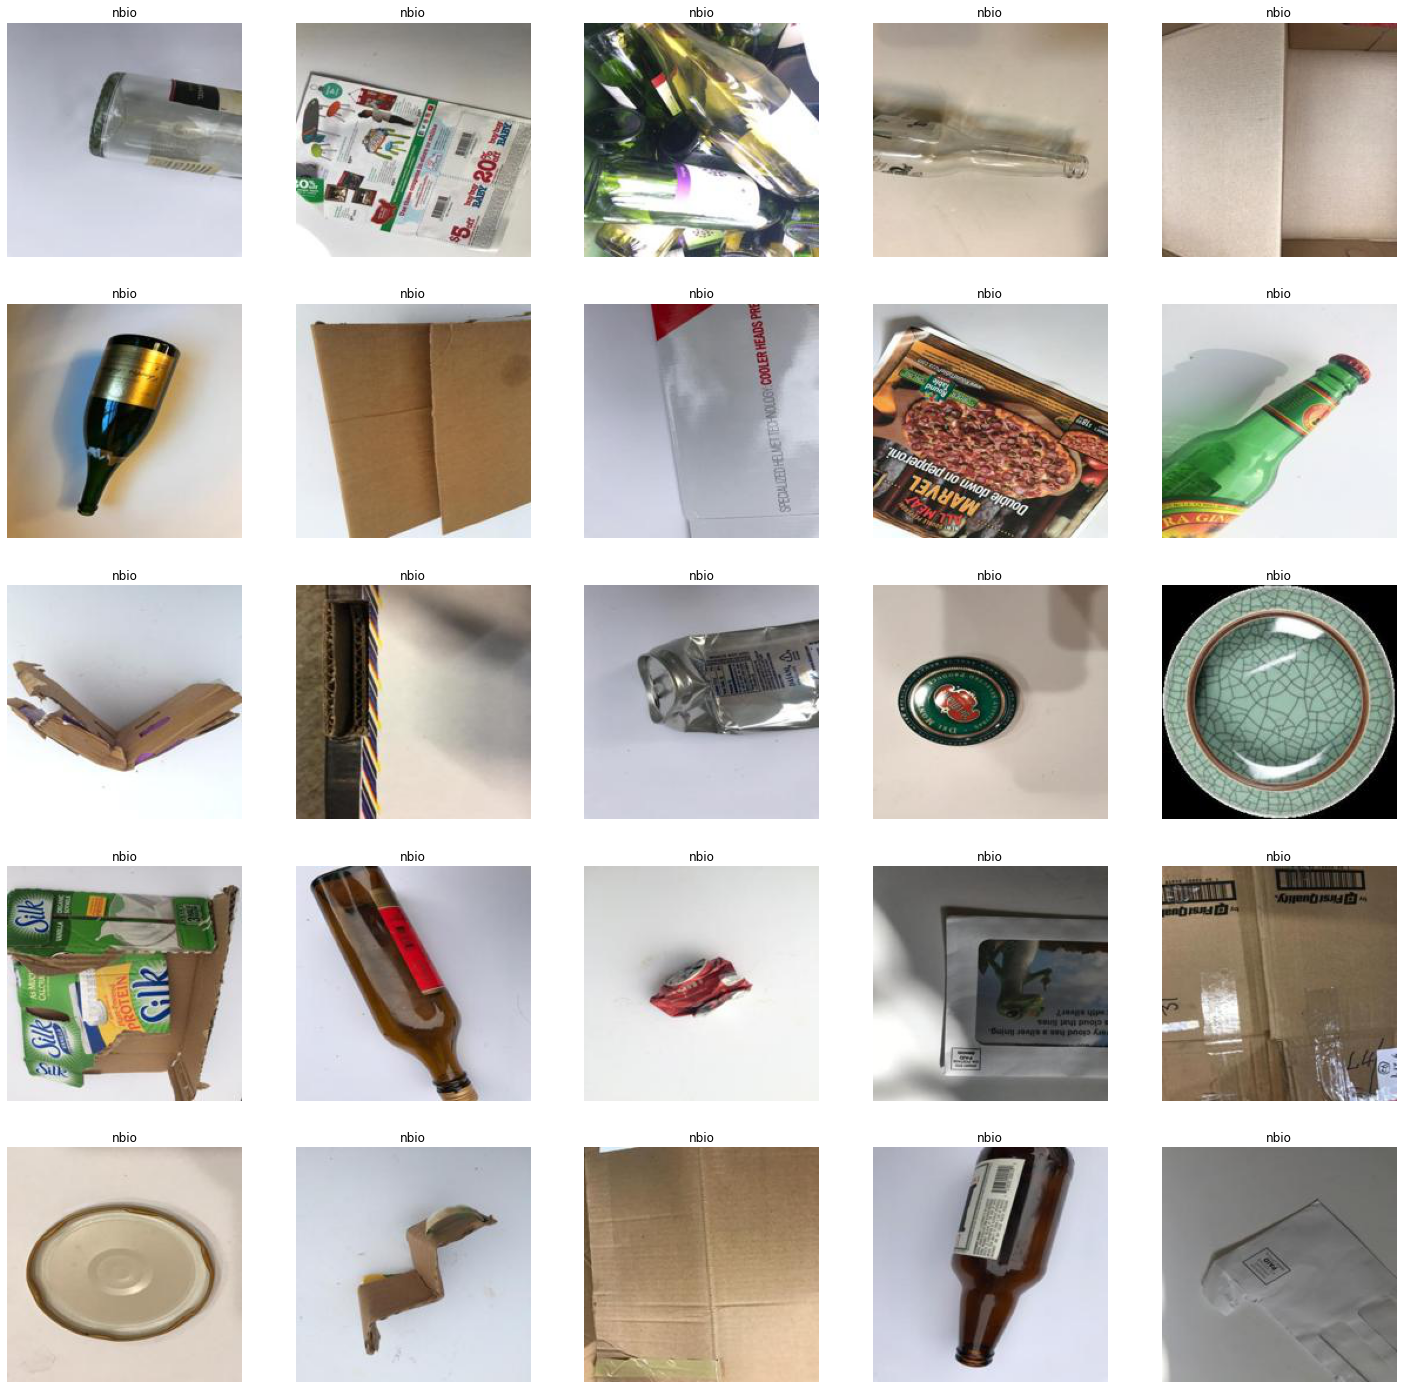

In [13]:
plt.figure(figsize=(25,25))
temp = df[df['label']==1]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('nbio')
    plt.axis('off')

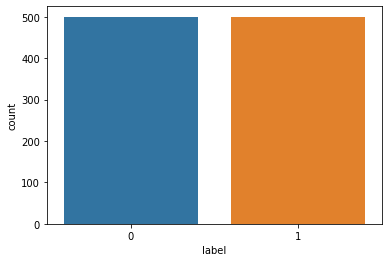

In [14]:
import seaborn as sns
sns.countplot(df['label'])

In [15]:
df['label'] = df['label'].astype('str')
df

images label
0      project/bio/TRAIN.1_BIODEG_ORI_371.jpg     0
1    project/nbio/TRAIN.1_NBIODEG_CCW_184.jpg     1
2      project/bio/TRAIN.1_BIODEG_ORI_135.jpg     0
3      project/bio/TRAIN.1_BIODEG_ORI_307.jpg     0
4       project/bio/TRAIN.1_BIODEG_ORI_82.jpg     0
..                                        ...   ...
995    project/bio/TRAIN.1_BIODEG_ORI_246.jpg     0
996  project/nbio/TRAIN.1_NBIODEG_CCW_292.jpg     1
997  project/nbio/TRAIN.1_NBIODEG_CCW_395.jpg     1
998  project/nbio/TRAIN.1_NBIODEG_CCW_122.jpg     1
999    project/bio/TRAIN.1_BIODEG_ORI_375.jpg     0

[1000 rows x 2 columns]

In [48]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [49]:
from keras_preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255,  # normalization of images
    rotation_range = 40, # augmention of images to avoid overfitting
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_generator = ImageDataGenerator(rescale = 1./255)

train_iterator = train_generator.flow_from_dataframe(
    train, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    batch_size=512, 
    class_mode='binary'
)

val_iterator = val_generator.flow_from_dataframe(
    test, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    batch_size=512, 
    class_mode='binary'
)

Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


In [50]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = Sequential([
                    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
                    MaxPool2D((2,2)),
                    Conv2D(32, (3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Conv2D(64, (3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(1, activation='sigmoid')
])

In [51]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)      

In [52]:
history = model.fit(train_iterator, epochs=10, validation_data=val_iterator)

Epoch 1/10
2/2 [==============================] - 4s 2s/step - loss: 0.6698 - accuracy: 0.5225 - val_loss: 1.5840 - val_accuracy: 0.4650
Epoch 2/10
2/2 [==============================] - 3s 1s/step - loss: 1.1269 - accuracy: 0.5138 - val_loss: 0.6125 - val_accuracy: 0.5400
Epoch 3/10
2/2 [==============================] - 3s 1s/step - loss: 0.6606 - accuracy: 0.4963 - val_loss: 0.6049 - val_accuracy: 0.5500
Epoch 4/10
2/2 [==============================] - 3s 2s/step - loss: 0.5698 - accuracy: 0.6338 - val_loss: 0.4887 - val_accuracy: 0.8450
Epoch 5/10
2/2 [==============================] - 3s 1s/step - loss: 0.4966 - accuracy: 0.9100 - val_loss: 0.4400 - val_accuracy: 0.8900
Epoch 6/10
2/2 [==============================] - 3s 2s/step - loss: 0.4258 - accuracy: 0.9125 - val_loss: 0.3652 - val_accuracy: 0.8700
Epoch 7/10
2/2 [==============================] - 3s 1s/step - loss: 0.3638 - accuracy: 0.8950 - val_loss: 0.2976 - val_accuracy: 0.8850
Epoch 8/10
2/2 [=========================

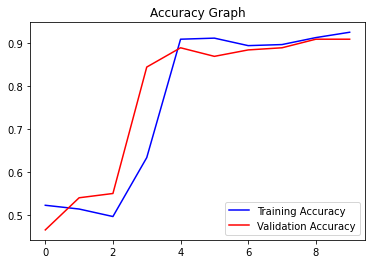

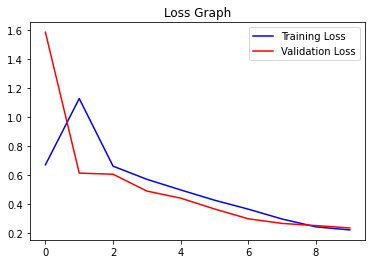

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [55]:
import PIL
img = np.array(PIL.Image.open('/content/TRAIN.2_BIODEG_ORI_0.jpg'))
path = '/content/TRAIN.2_BIODEG_ORI_0.jpg'

In [ ]:

pred= model.predict(img)

In [ ]:
train_iterator = train_generator.flow_from_dataframe(
    img, 
    target_size=(128,128), 
    batch_size=512, 
    class_mode='binary'
)

### ##############################